## Load and Visualize dataset

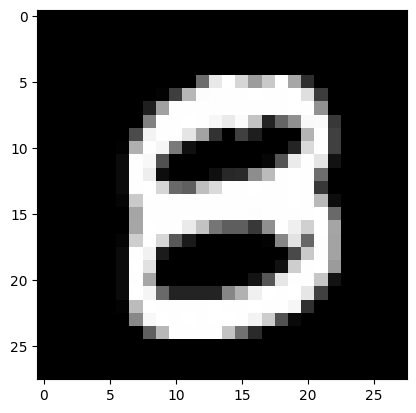

In [1]:
import numpy as np
import matplotlib.pyplot as plt

with np.load('mnist_files/mnist_all.npz') as data:
    train_X = data['train_X']
    test_X = data['test_X']
    train_Y = data['train_Y']
    test_Y = data['test_Y']    

plt.imshow(train_X[np.random.randint(60000)], cmap=plt.get_cmap('gray'))
plt.show()

## Reshape Image data

In [2]:
train_X = np.reshape(train_X, (train_X.shape[0], -1)).T
test_X = np.reshape(test_X, (test_X.shape[0], -1)).T

In [3]:
train_X.shape

(784, 60000)

In [4]:
test_X.shape

(784, 10000)

## Add bias (offset) term to data

In [5]:
train_bias = np.ones((1, train_X.shape[1]))
test_bias = np.ones((1, test_X.shape[1]))
train_X = np.vstack((train_X, train_bias))
test_X = np.vstack((test_X, test_bias))

In [6]:
train_X.shape

(785, 60000)

In [7]:
test_X.shape

(785, 10000)

## Convert Labels to One hot vectors

In [8]:
one_hot_train = np.zeros((10, train_Y.shape[0]))
one_hot_test = np.zeros((10, test_Y.shape[0]))

In [9]:
for i, label in enumerate(train_Y):
    one_hot_train[label, i] = 1

for i, label in enumerate(test_Y):
    one_hot_test[label, i] = 1

In [10]:
one_hot_train.shape

(10, 60000)

In [11]:
one_hot_test.shape

(10, 10000)

## Dimensionality

#### $$\hat{x} = (785,1) $$
#### $$\hat{y} = (10,1) $$
#### $$W_1 = (p, 785) $$
#### $$W_2 = (10, p) $$
#### $$z = (p, 1) $$
#### $$a = (p, 1) $$
#### Where, $p = $ Hidden Dimension size

## Gradients

#### $$ \nabla_{W_1} \mathcal{L} = \frac{1}{M}\sum_{m=1}^{M} (\hat{y_m} - y_m)z_m^{T}$$
#### $$ \nabla_{W_2} \mathcal{L} = \frac{1}{M}\sum_{m=1}^{M} [(\hat{y_m} - y_m)^{T}W_2D_\phi(W_1x_m)]^{T}x_m^{T}$$

#### Where, $$D_\phi(W_1x_m) = (1-\sigma{(a)}) \cdot \sigma{(a)}$$

## Helper Functions

In [ ]:
def sigmoid(x):
    transform = np.where(
        x>=0,
        1 / (1 + np.exp(-x)),
        np.exp(x) / (np.exp(x) + 1)
    )
    
    return transform

def softargmax(V):
    exp_v = np.exp(V)
    out = np.reciprocal(np.sum(exp_v, axis=0)) * exp_v
    return out

def loss(Y, Y_hat):
    #Y and Y_hat are matrices with one
    #column for every data point
    log_yhat = np.log(Y_hat + 1e-9) #avoid error with np.log(0)
    mult_term = np.multiply(Y, log_yhat)
    cross_entropy = -(np.mean(np.sum(mult_term, axis=0)))
    return cross_entropy

def feed_forward(x,w1,w2):
    a=w1 @ x #(p, m)(m, 1) = (p, 1)
    z=sigmoid(a) #(p, 1) -> (p, 1)
    Yhat=softargmax(w2@z) #(out_size, p)(p, 1) = (out_size, 1)
    return (Yhat,a,z)

def sigmoid_derivative(z):
    out = (1 - z) * z
    return out

def back_propagate(x,y,w2,z,yhat,m):
    #(10, p) = (10, N)(N, p)
    dL_dw2 = ((yhat-y) @ z.T) / m
    #(p,N) = (p,N)
    dz_da = sigmoid_derivative(z)
    #(p, N) = (p, 10)(10,N)
    dL_dz = (w2.T @ (yhat-y)) / m
    #(p, N) = (p, N)*(p, N)
    dL_da = dL_dz * dz_da
    #(785, N)
    da_dw1 = x
    #(p,785) = (p, N)(N, 785)
    dL_dw1 = dL_da @ da_dw1.T
    
    return (dL_dw1, dL_dw2)

def check_accuracy(x,y,w1,w2):
    #Returns the fraction of correctly classified 
    #images when using weights W1 and W2

    preds = softargmax(w2 @ sigmoid(w1@x))
    pred_classes = np.argmax(preds, axis=0)
    true_classes = np.argmax(y, axis=0)
    correct = np.sum(pred_classes == true_classes)
    percent_correct = correct / true_classes.shape[0]
    return percent_correct

## Randomly Initialize Weights

In [57]:
#hidden dim size
p = 35

#Initialize weights
w1 = np.random.normal(0, 0.6, size=(p, 785))
w2 = np.random.normal(0, 0.6, size=(10, p))

## Initial Accuracy

In [58]:
print('Initial accuracy on training data: ',
 check_accuracy(train_X,one_hot_train,w1,w2)
)
print('Initial accuracy on test data: ',
 check_accuracy(test_X,one_hot_test,w1,w2)
)

Initial accuracy on training data:  0.09028333333333333
Initial accuracy on test data:  0.0867


## Training Loop

#### Define parameters

In [61]:
alpha = .1
batch_size = 100
num_batches = int(train_X.shape[1]/batch_size)
epochs = 30

In [60]:
def shuffle_data(train_X, train_Y):
    shuffle_index = np.arange(train_X.shape[1])
    np.random.shuffle(shuffle_index)
    
    return train_X.T[shuffle_index].T, train_Y.T[shuffle_index].T

In [62]:
epoch_loss = []
epoch_accuracy = []

for epoch in range(epochs):
    #shuffle data
    train_X, one_hot_train = shuffle_data(train_X, one_hot_train)

    for b in range(num_batches):
        batch_begin = b*batch_size
        batch_end = b*batch_size + batch_size

        batch_x = train_X[:, batch_begin:batch_end]
        batch_y = one_hot_train[:, batch_begin:batch_end]

        #Forward propagate
        yhat, a, z = feed_forward(batch_x, w1, w2)

        #backpropagate
        dL_dw1, dL_dw2 = back_propagate(
            batch_x,
            batch_y,
            w2,
            z,
            yhat,
            batch_size
        )

        #Update weights
        w1 = w1 - (alpha * dL_dw1)
        w2 = w2 - (alpha * dL_dw2)

    ce_loss = loss(batch_y, yhat)
    epoch_loss.append(ce_loss)
    
    accuracy = check_accuracy(test_X, one_hot_test, w1, w2)
    epoch_accuracy.append(accuracy)

    print(f'Epoch {epoch} - Loss: {ce_loss}, Accuracy: {accuracy}')

Epoch 0 - Loss: 0.8143926624502272, Accuracy: 0.7573
Epoch 1 - Loss: 0.5100124037472871, Accuracy: 0.827
Epoch 2 - Loss: 0.5143121446052796, Accuracy: 0.8558
Epoch 3 - Loss: 0.48321402499760013, Accuracy: 0.8694
Epoch 4 - Loss: 0.4882748212473087, Accuracy: 0.8778
Epoch 5 - Loss: 0.5771436471853552, Accuracy: 0.8854
Epoch 6 - Loss: 0.3815821123366755, Accuracy: 0.8895
Epoch 7 - Loss: 0.38722059877491205, Accuracy: 0.8949
Epoch 8 - Loss: 0.3447509921951849, Accuracy: 0.8982
Epoch 9 - Loss: 0.33982131468452503, Accuracy: 0.9028
Epoch 10 - Loss: 0.266131261365916, Accuracy: 0.9048
Epoch 11 - Loss: 0.4001994688186388, Accuracy: 0.9075
Epoch 12 - Loss: 0.2810675672771683, Accuracy: 0.9097
Epoch 13 - Loss: 0.3495603877753636, Accuracy: 0.9116
Epoch 14 - Loss: 0.26562150996393596, Accuracy: 0.9134
Epoch 15 - Loss: 0.24775044912662497, Accuracy: 0.9147
Epoch 16 - Loss: 0.20627286702265868, Accuracy: 0.9168
Epoch 17 - Loss: 0.2973350857218098, Accuracy: 0.9176
Epoch 18 - Loss: 0.299550355041952

Text(0.5, 1.0, 'Training Loss and Test Accuracy')

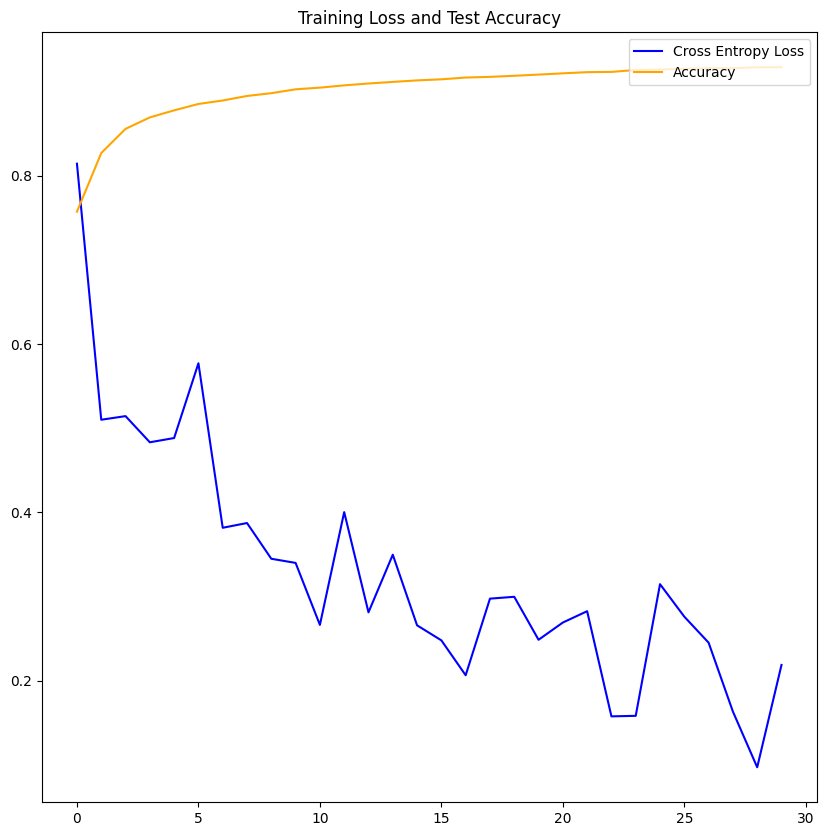

In [63]:
fig = plt.figure(figsize=(10,10))
xaxis = np.arange(epochs)
plt.plot(xaxis, epoch_loss, color='blue', label='Cross Entropy Loss')
plt.plot(xaxis, epoch_accuracy, color='orange', label='Accuracy')
plt.legend(loc='upper right')
plt.title('Training Loss and Test Accuracy')